# Кредитный скоринг 

In [1]:
import pandas as pd
import numpy as np

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [3]:
df = pd.read_csv('credit_card_default_analysis.csv')
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2      0      0   
1   2     120000    2          2         2   26      0      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57      0      0      0      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default  
0         0         0         0        1  
1      1000         0      2000        1  
2      1000      1000      5000        0  
3      1100      1069      1000        0  
4      9000       689       679        0  

[5 rows x 25 columns]

In [4]:
df.columns

Index([u'ID', u'LIMIT_BAL', u'SEX', u'EDUCATION', u'MARRIAGE', u'AGE',
       u'PAY_0', u'PAY_2', u'PAY_3', u'PAY_4', u'PAY_5', u'PAY_6',
       u'BILL_AMT1', u'BILL_AMT2', u'BILL_AMT3', u'BILL_AMT4', u'BILL_AMT5',
       u'BILL_AMT6', u'PAY_AMT1', u'PAY_AMT2', u'PAY_AMT3', u'PAY_AMT4',
       u'PAY_AMT5', u'PAY_AMT6', u'default'],
      dtype='object')

## 1.Задание Размер кредитного лимита (LIMIT_BAL). 

В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?


In [5]:
fig = go.Figure(data=go.Bar(x=df['default'].unique(), y=df['default'].value_counts()))
fig.show()

In [6]:
fig = go.Figure(data=go.Box(x=df['default'], y=df['LIMIT_BAL']))
fig.show()

In [7]:
fig = go.Figure()
fig.add_traces(go.Histogram(x=df[df['default']==1]['LIMIT_BAL'], nbinsx=20))
fig.add_traces(go.Histogram(x=df[df['default']==0]['LIMIT_BAL'], nbinsx=20))
fig.show()

Cгенерируем 1000 подвыборок методом bootstrap и подсчитаем среднее значение медиан распределений и доверительный интервал для разности медиан

In [8]:
def get_bootstrap_samples(data, n_samples): #функция генерации n_samples выборок из data, методом bootstrap
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha): #функция генерации доверительного интервала для статисики
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [10]:
no_def_lim = map(np.median, get_bootstrap_samples(df[df.default == 0].LIMIT_BAL.values, 1000))
with_def_lim = map(np.median, get_bootstrap_samples(df[df.default == 1].LIMIT_BAL.values, 1000))

print 'no_def_lim median: ', sum(no_def_lim) / float(len(no_def_lim))
print 'with_def_lim median: ', sum(with_def_lim) / float(len(with_def_lim))

delta_median_scores = map(lambda x: x[0] - x[1], zip(no_def_lim, with_def_lim))

print 'delta ', sum(delta_median_scores) / float(len(delta_median_scores))

print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

no_def_lim median:  150020.0
with_def_lim median:  89780.0
delta  60240.0
95% confidence interval for the difference between medians [60000. 70000.]


Видим, что значение медиан подвыборок значительно отличается. Доверительный интервал для разницы не содержит 0, разница статистически значима.

 b) Для проверки гипотезы о равенстве распределений используем непараметрический критерий Манна-Уитни.

In [11]:
from scipy import stats
data_with_default = df[df['default']==1]['LIMIT_BAL']
data_no_default = df[df['default']==0]['LIMIT_BAL']
stats.mannwhitneyu(data_with_default, data_no_default)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Видим, что гипотеза о равенстве распределений уверенно отвергается.

### 2.Пол (SEX).

Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия) 

In [32]:
data_with_default = df[df['default']==1]
data_no_default = df[df['default']==0]

In [33]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "bar"}, {"type": "bar"}]], subplot_titles=[])
fig.add_trace(go.Bar(x=data_with_default['SEX'].unique(), y=data_with_default['SEX'].value_counts(), name='with_default'), 1, 1)
fig.add_trace(go.Bar(x=data_no_default['SEX'].unique(), y=data_no_default['SEX'].value_counts(), name='no_default'), 1, 2)
fig.show()

Проверим гипотезу о равенстве доли мужчин в группе вернувших кредит и не вернувших.

H0: доля мужчин в обеих группах одинаковая.

H1: доля мужчин разная

Используем двухсторонний z-критерий проверки равенства доли в несвязанных выборках

In [40]:
import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [23]:
def proportions_diff_z_stat_ind(sample1, sample2): #вычисление значения z-статистики
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'): # вычисление уровня значимости
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [35]:
sample1 = data_with_default
sample2 = data_no_default
sample1['SEX'] = sample1['SEX'].map({1:1,2:0})
sample2['SEX'] = sample2['SEX'].map({1:1,2:0})

C:\Users\Vladuk\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Vladuk\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [41]:
z_stat = proportions_diff_z_stat_ind(sample1['SEX'].values, sample2['SEX'].values)
print 'z_stat=', z_stat
p_value = proportions_diff_z_test(z_stat, alternative = 'two-sided')
print 'p_value=', p_value

z_stat= 6.921375088562897
p_value= 4.472866521609831e-12


In [47]:
print sample1['SEX'].values.sum()/float(len(sample1['SEX'].values))
print sample2['SEX'].values.sum()/float(len(sample2['SEX'].values)) #точечные оценки для долей мужчин в выборках

0.43294153104279687
0.38585002568053417


In [43]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)
print "confidence interval: [%f, %f]" % proportions_confint_diff_ind(sample1['SEX'].values, sample2['SEX'].values)

confidence interval: [0.033635, 0.060548]


95% доверительный интервал для разности долей не содержит 0. Гипотеза о равенстве доли мужчин в распределениях отвергается.  В выборке людей, которые не вернули кредит, мужчин больше.

### 3.Образование (EDUCATION).

Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ? 

In [149]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "bar"}, {"type": "bar"}]], subplot_titles=[])
fig.add_trace(go.Histogram(x=df[df['default']==1]['EDUCATION'], name='with_default', nbinsx=7), 1, 1)
fig.add_trace(go.Histogram(x=df[df['default']==0]['EDUCATION'], name='no_default', nbinsx=7), 1, 2)
fig.show()

In [115]:
table = df.pivot_table('ID', index='EDUCATION', columns='default', aggfunc='count', fill_value=0, margins=True)
table

default        0     1    All
EDUCATION                    
0             14     0     14
1           8549  2036  10585
2          10700  3330  14030
3           3680  1237   4917
4            116     7    123
5            262    18    280
6             43     8     51
All        23364  6636  30000

In [116]:
def table_wait(table):
    table_wait = table.copy()
    K1 = table.shape[0]-1
    K2 = table.shape[1]-1
    for i in range(0,K1):
        for j in range(0,K2):
            table_wait[j][i] = table['All'][i]*table.loc['All'][j]/float(table.loc['All']['All'])
    return table_wait

In [117]:
table_wait = table_wait(table)
table_wait

default        0     1    All
EDUCATION                    
0             10     3     14
1           8243  2341  10585
2          10926  3103  14030
3           3829  1087   4917
4             95    27    123
5            218    61    280
6             39    11     51
All        23364  6636  30000

In [119]:
def stat_x2(table, table_wait):
    K1 = table.shape[0]-1
    K2 = table.shape[1]-1
    sum_it = 0
    for i in range(0,K1):
        for j in range(0,K2):
            ch = (table[j][i]-table_wait[j][i])**2
            zn = table_wait[j][i]
            sl = ch/float(zn)
            sum_it += sl
    return sum_it

In [120]:
stat_x2(table, table_wait)

163.35251598178417

In [121]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(table)
print 'stat=',chi2 #значение статистики
print 'p=', p #достигаемый уровень значимости
print 'dof=', dof #число степеней свободы
print 'ex=', ex #ожидаемые частоты обытий

stat= 163.2165578699707
p= 1.5987086709565762e-27
dof= 14
ex= [[1.0903200e+01 3.0968000e+00 1.4000000e+01]
 [8.2435980e+03 2.3414020e+03 1.0585000e+04]
 [1.0926564e+04 3.1034360e+03 1.4030000e+04]
 [3.8293596e+03 1.0876404e+03 4.9170000e+03]
 [9.5792400e+01 2.7207600e+01 1.2300000e+02]
 [2.1806400e+02 6.1936000e+01 2.8000000e+02]
 [3.9718800e+01 1.1281200e+01 5.1000000e+01]
 [2.3364000e+04 6.6360000e+03 3.0000000e+04]]


In [148]:
def table_razn(table, table_wait):
    res_table = table_wait.copy()
    res_table = res_table.astype('float')
    K1 = table.shape[0]-1
    K2 = table.shape[1]-1
    for i in range(0,K1):
        for j in range(0,K2):
            temp = (table[j][i] - table_wait[j][i])
            res = temp/float(table['All'][i])
            res_table[j][i] = res
    return res_table
table_razn(table, table_wait)

default               0            1      All
EDUCATION                                    
0              0.285714    -0.214286     14.0
1              0.028909    -0.028814  10585.0
2             -0.016108     0.016180  14030.0
3             -0.030303     0.030506   4917.0
4              0.170732    -0.162602    123.0
5              0.157143    -0.153571    280.0
6              0.078431    -0.058824     51.0
All        23364.000000  6636.000000  30000.0

Критерий хи квадрат уверенно отвергает гипотезу о независимости вероятности возвращения кредита от образования пользователя.

### 4.Семейное положение (MARRIAGE).

Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [150]:
df['MARRIAGE'].value_counts() #видим, что признак категориальный

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

Признак категориальный, применим критерий хи квадрат для проверки гипотезы H0:независимости признаков MARRIAGE и default 

In [151]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "bar"}, {"type": "bar"}]], subplot_titles=['MARRIAGE DISTRIBUTION'])
fig.add_trace(go.Histogram(x=df[df['default']==1]['MARRIAGE'], name='with_default', nbinsx=4), 1, 1)
fig.add_trace(go.Histogram(x=df[df['default']==0]['MARRIAGE'], name='no_default', nbinsx=4), 1, 2)
fig.show()

In [152]:
table = df.pivot_table('ID', index='MARRIAGE', columns='default', aggfunc='count', fill_value=0, margins=True)
table

default       0     1    All
MARRIAGE                    
0            49     5     54
1         10453  3206  13659
2         12623  3341  15964
3           239    84    323
All       23364  6636  30000

In [153]:
chi2, p, dof, ex = chi2_contingency(table)
print 'stat=',chi2 #значение статистики
print 'p=', p #достигаемый уровень значимости
print 'dof=', dof #число степеней свободы
print 'ex=', ex #ожидаемые частоты обытий

stat= 35.66239583433609
p= 2.024320753695656e-05
dof= 8
ex= [[4.20552000e+01 1.19448000e+01 5.40000000e+01]
 [1.06376292e+04 3.02137080e+03 1.36590000e+04]
 [1.24327632e+04 3.53123680e+03 1.59640000e+04]
 [2.51552400e+02 7.14476000e+01 3.23000000e+02]
 [2.33640000e+04 6.63600000e+03 3.00000000e+04]]


In [160]:
def kramer(table):
    K1 = table.shape[0]-1
    K2 = table.shape[1]-1
    n = table.loc['All']['All']
    chi2, p, dof, ex = chi2_contingency(table)
    return np.sqrt(chi2/float(n*(min(K1,K2)-1)))
print kramer(table) #коэффициент V Крамера (связь есть)

0.034478203662766466


Гипотеза о независимости признаков MARRIAGE и default уверенно отвергается.

### 5.Возраст (AGE).

Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: 

a) о равенстве медианных значений возрастов людей 

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [161]:
fig = go.Figure(data=go.Box(x=df['default'], y=df['AGE']))
fig.show()

Box диаграммы показывают равенство медианных значний двух распределений.

In [163]:
fig = go.Figure()
fig.add_traces(go.Histogram(x=df[df['default']==1]['AGE'], name='with_default'))
fig.add_traces(go.Histogram(x=df[df['default']==0]['AGE'], name='no_default'))
fig.show()

Проверим гипотезу о нормальности распределений по возрасту. Построим Q-Q графики и применим критерий Шапиро-Уилка

Populating the interactive namespace from numpy and matplotlib


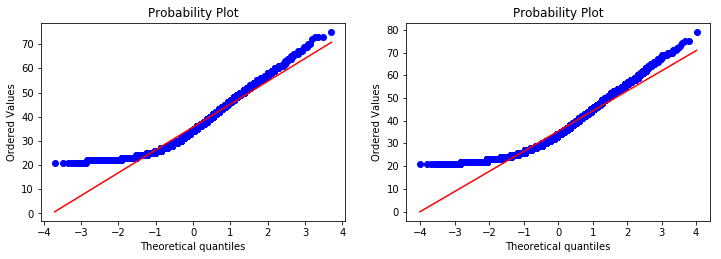

In [165]:
import scipy
from statsmodels.stats.weightstats import *
%pylab inline
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(df[df['default']==1]['AGE'], dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(df[df['default']==0]['AGE'], dist="norm", plot=pylab)
pylab.show()

In [166]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(df[df['default']==1]['AGE'])
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(df[df['default']==0]['AGE'])

Shapiro-Wilk normality test, W-statistic: 0.950164, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.949614, p-value: 0.000000


C:\Users\Vladuk\Anaconda2\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning:

p-value may not be accurate for N > 5000.



Критерий Шапиро-Уилка уверенно отвергает гипотезу о нормальности распределений (т.к. выборки ограничены снизу, кредиты не выдаются лицам младше 21 года). Нельзя применять к выборкам критерий Стьюдента.

Проверим гипотезу о равенстве медианых значений бутстреп методом. Cгенерируем 1000 подвыборок методом bootstrap и подсчитаем среднее значение медиан распределений и доверительный интервал для разности медиан

In [167]:
no_def_age = map(np.median, get_bootstrap_samples(df[df.default == 0].AGE.values, 1000))
with_def_age = map(np.median, get_bootstrap_samples(df[df.default == 1].AGE.values, 1000))

print 'no_def_age median: ', sum(no_def_age) / float(len(no_def_age))
print 'with_def_age median: ', sum(with_def_age) / float(len(with_def_age))

delta_median_scores_age = map(lambda x: x[0] - x[1], zip(no_def_age, with_def_age))

print 'delta ', sum(delta_median_scores_age) / float(len(delta_median_scores_age))

print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores_age, 0.05)

no_def_age median:  34.0
with_def_age median:  34.0855
delta  -0.0855
95% confidence interval for the difference between medians [-1.  0.]


95% Доверительный интервал содержит 0, следовательно гипотеза о том, что медианы в выборках разные не отвергается.

### b) Проверим гипотезу о равенстве распределений с помощью критерия Манна-Уитни

In [168]:
stats.mannwhitneyu(df[df['default']==1]['AGE'],df[df['default']==0]['AGE'])

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Уровень значимости значительно больше 0.05, следовательно критерий Манна-Уитни не отвергает гипотезу о равенстве двух распределений. Данный факт свидетельствует о том, что нет никакой связи между возрастом и вероятностью дефолта клиента